In [1]:
# import
import talib
import pandas as pd
import numpy as np
from datetime import timedelta, datetime as dt
from pandas_datareader.data import get_data_yahoo

from matplotlib import ticker, style
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, date2num
from matplotlib.finance import candlestick_ochl
from matplotlib import pyplot as plt, gridspec

from pylab import rcParams

from datetime import datetime as dt, timedelta

style.use('ggplot')

In [2]:
# getting data
date2 = dt.now().date()
date1 = date2 - timedelta(days=90)        
df = get_data_yahoo('BAC', date1, date2)
df[-3:]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-12-07,22.190001,22.57,21.950001,22.570000,166808000,22.570000
2016-12-08,22.790001,23.24,22.690001,22.950001,182248500,22.950001
2016-12-09,22.950001,23.17,22.780001,23.090000,129135900,23.090000


In [3]:
date1 = date2 - timedelta(days=300)        
df = get_data_yahoo('BAC', date1, date2)
len(df)  # days

209

In [6]:
rsi_values = talib.RSI(df['Close'].values, timeperiod=14)
df['RSI'] = pd.Series(rsi_values, index=df.index.values)
df[12:16][['RSI', 'Close']]

,RSI,Close
Date,,
2016-03-03,NaN,13.50
2016-03-04,NaN,13.54
2016-03-07,69.161677,13.53
2016-03-08,60.060000,13.06


In [7]:
adx_values = talib.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
# NOTE: The ADX function has an unstable period.
df['ADX'] = pd.Series(adx_values, index=df.index.values)
df[-3:][['High', 'Low', 'Close', 'ADX']]

,High,Low,Close,ADX
Date,,,,
2016-12-07,22.57,21.950001,22.570000,54.914900
2016-12-08,23.24,22.690001,22.950001,56.340448
2016-12-09,23.17,22.780001,23.090000,57.664171


In [8]:
plus_di_values = talib.PLUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
df['PLUS_DI'] = pd.Series(plus_di_values, index=df.index.values)
df[-3:][['High', 'Low', 'Close', 'PLUS_DI']]

,High,Low,Close,PLUS_DI
Date,,,,
2016-12-07,22.57,21.950001,22.570000,49.301661
2016-12-08,23.24,22.690001,22.950001,53.917773
2016-12-09,23.17,22.780001,23.090000,51.006509


In [9]:
minus_di_values = talib.MINUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
df['MINUS_DI'] = pd.Series(minus_di_values, index=df.index.values)
df[-3:][['High', 'Low', 'Close', 'MINUS_DI']]

,High,Low,Close,MINUS_DI
Date,,,,
2016-12-07,22.57,21.950001,22.570000,8.523512
2016-12-08,23.24,22.690001,22.950001,7.747442
2016-12-09,23.17,22.780001,23.090000,7.329122


In [12]:
# Visual verification
def plot_data(df, instances=None):
    fig = plt.figure(figsize=(20, 25)) 
    gs = gridspec.GridSpec(4, 1, height_ratios=[3, 2, 1, 1]) 

    # Plot the candlestick    
    ax1 = plt.subplot(gs[0])
    candlestick_ochl(
        ax1, 
        ((date2num(r.Index), r.Open, r.Close, r.High, r.Low) for r in df.itertuples()), 
        width=1,  
        colorup='g',  
        colordown='r',
    )    
    ax1.set_ylim(df.Low.min(), df.High.max())
    
    # Plot the volume overlay
    ax2 = plt.subplot(gs[1])    
    
    pos_volumes = df[df.Close >= df.Open]
    neg_volumes = df[df.Close < df.Open]
    pos_dates = [date2num(date) for date in pos_volumes.index]
    neg_dates = [date2num(date) for date in neg_volumes.index]
    ax2.bar(pos_dates, pos_volumes['Volume'].tolist(), color='green', align='center', label="Positive")
    ax2.bar(neg_dates, neg_volumes['Volume'].tolist(), color='red', align='center', label="Negative") 
    if 'Recent5daysAvgVolume' in df.columns.values:
        ax2.bar([date2num(date) for date in df.index], df['Recent5daysAvgVolume'].tolist(),
                bottom=df['Volume'].tolist(),
                color='blue', align='center', label="Avg5days")    
    

    # RSI Plot
    rsi_df = df[df.RSI.notnull()]
    rsi_values = rsi_df['RSI'].values
    rsi_indexes = [date2num(date) for date in rsi_df.index]
    ax3 = plt.subplot(gs[2])
    ax3.plot(rsi_indexes, rsi_values, 'k')    

    ax4 = ax3.twinx()
    over_70_line = np.array([70] * len(rsi_values))
    ax4.fill_between(rsi_indexes, 70, rsi_values, where=rsi_values >= over_70_line, 
                     facecolor='green', interpolate=True)
    
    y_min, y_max = rsi_df.RSI.min() - 5, rsi_df.RSI.max() + 5
    ax3.set_ylim(y_min, y_max)
    ax4.set_ylim(y_min, y_max) 


    # Create figure
    ax5 = plt.subplot(gs[3])
    ax5.plot(df.index.values, df.ADX.values, 'k', label="ADX")
    ax5.plot(df.index.values, df.PLUS_DI.values, 'g', label="+DI")
    ax5.plot(df.index.values, df.MINUS_DI.values, 'r', label="- DI")
    
    
    # highlight instance days, and show only -90 + 50 days
    x_mins, x_maxs = [], []
    if instances:
        for instance in instances:
            
            gap_index = df.index.get_loc(instance)
            window = df[gap_index - 90 : gap_index + 50]        
            x_mins.append(window.index.min())
            x_maxs.append(window.index.max())
            
            # highlight
            for ax in (ax1, ax2, ax3, ax5):
                ax.axvspan(instance - timedelta(days=1), 
                           instance + timedelta(days=1), color='yellow', alpha=0.3)    
    
    x_min, x_max = df.index.min(), df.index.max()
    if x_mins and x_maxs:
        x_min, x_max = max(x_min, min(x_mins)), min(x_max, max(x_maxs))
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    ax3.set_xlim(x_min, x_max)
    ax5.set_xlim(x_min, x_max)
    
    # add ticks 
    weekFormatter = DateFormatter('%b %d')
    mondays = WeekdayLocator(MONDAY)
    ax1.xaxis.set_major_locator(mondays)
    ax1.xaxis.set_major_formatter(weekFormatter)
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    
    ax2.legend(fancybox=True, loc='best')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x,p: "%dM" % (x / 1000000)))
    ax2.set_ylabel('Volume, M')
    ax2.xaxis.set_major_locator(mondays)  
    ax2.xaxis.set_major_formatter(weekFormatter)
       
    ax3.set_ylabel('RSI')
    ax3.yaxis.set_label_position("right")
    ax3.xaxis.set_major_locator(mondays)
    ax3.xaxis.set_major_formatter(weekFormatter)
    
    ax5.legend(fancybox=True, loc='best')
    ax5.yaxis.tick_right()
    ax5.set_ylabel('ADX')
    ax5.yaxis.set_label_position("right")
    ax5.xaxis.set_major_locator(mondays) 
    ax5.xaxis.set_major_formatter(weekFormatter)    
    
    plt.show()

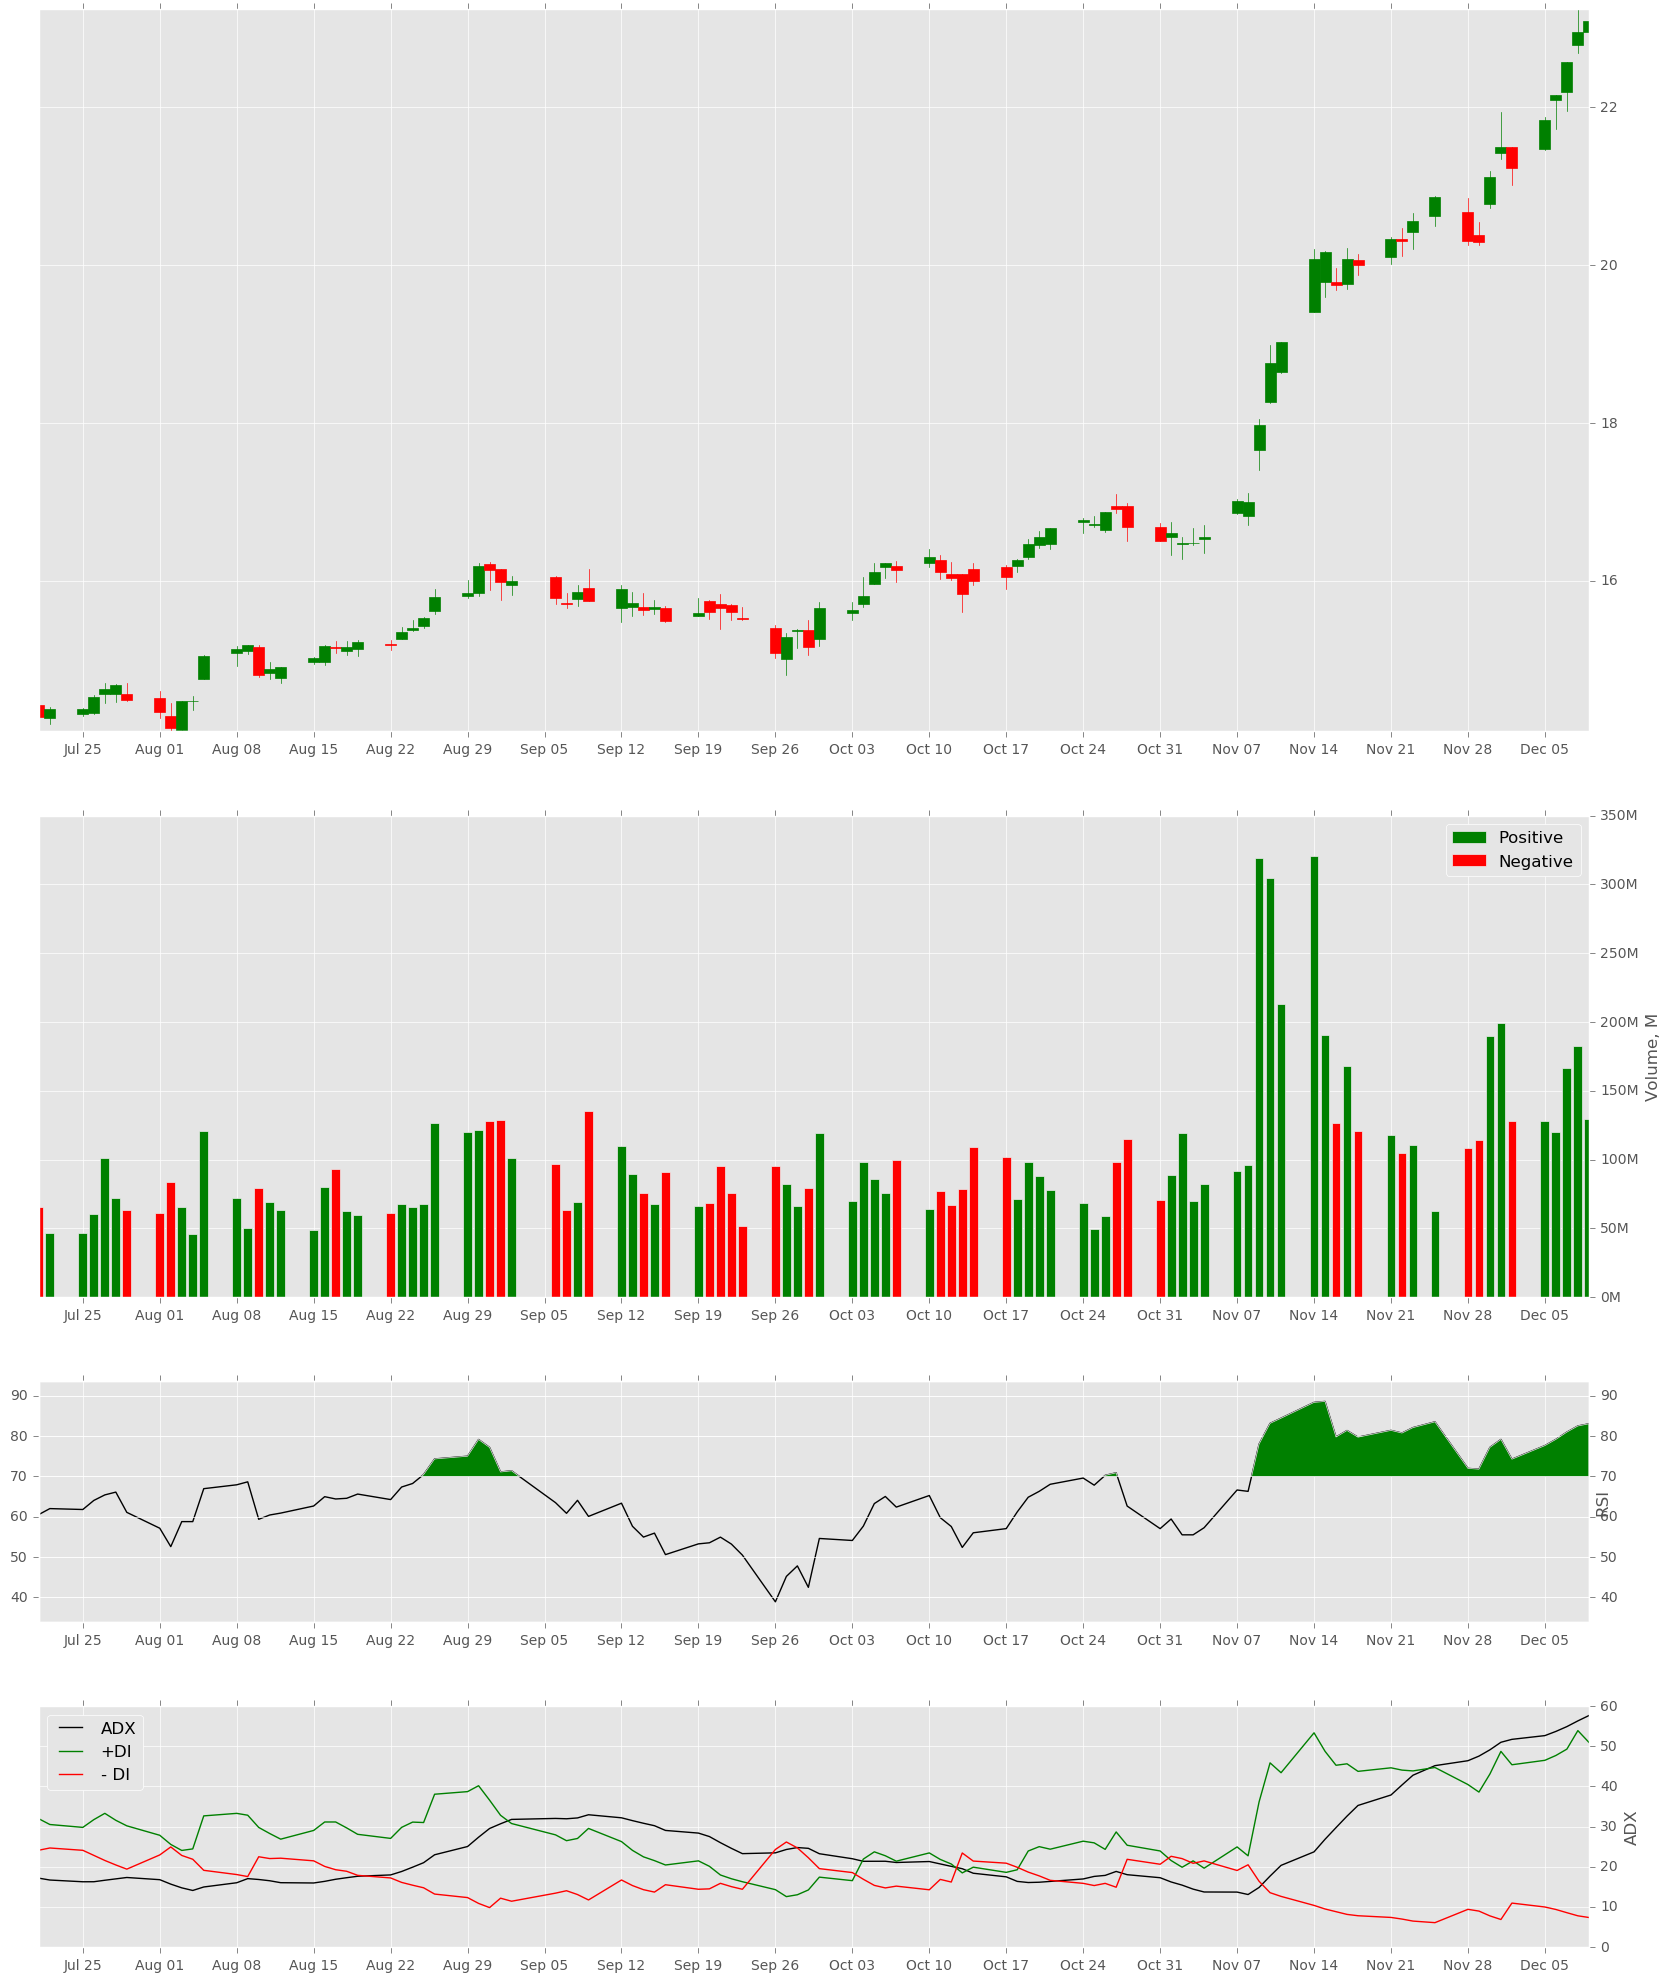

In [13]:
plot_data(df[-100:])

# PATTERN IDENTIFICATION ALGORITHM

Patter conditions:
1. Identify gaps of over 3% (opening price > 3% than closing price of the previous day)  ’If YES’ and 

2. Gap day close price should make a new 90 days high ’If YES’ and 

3. Gap day volume should be 50% higher than the average of the previous 5 days ’If YES’ and 

4. RSI should be higher than 70 ’If YES’ and 

5. ADX green line should be > ADX red lines ’If YES’ then:

In [17]:
# 1
df['OpeningGap'] = pd.Series((df.Open - df.Close.shift(1)) / df.Close.shift(1) * 100, index=df.index.values)
fdf = df[df.OpeningGap >= 3]
fdf[-3:][['Open', 'Close', 'OpeningGap']]

,Open,Close,OpeningGap
Date,,,
2016-06-28,12.57,12.700000,3.201970
2016-11-09,17.66,17.969999,3.882353


In [18]:
# 2
df['Prev89daysMaxClose'] = df.Close.rolling(window=89).max()
df['MaxHigh90Days'] = df.Close > df.Prev89daysMaxClose.shift(1)
fdf = df[df.MaxHigh90Days] 
fdf[-3:][['MaxHigh90Days', 'Open', 'Close']]

,MaxHigh90Days,Open,Close
Date,,,
2016-12-07,True,22.190001,22.570000
2016-12-08,True,22.790001,22.950001
2016-12-09,True,22.950001,23.090000


In [19]:
# 3
df['Recent5daysAvgVolume'] = df.Volume.rolling(window=5).mean()
df['VolumeGap'] = ((df.Volume - df.Recent5daysAvgVolume.shift(1)) / df.Recent5daysAvgVolume.shift(1))
fdf = df[df.VolumeGap > 0.5] 
fdf[-3:][['Volume', 'Recent5daysAvgVolume', 'VolumeGap']]

,Volume,Recent5daysAvgVolume,VolumeGap
Date,,,
2016-11-14,320959900,250851700.0,0.565841
2016-11-30,190151700,117286280.0,0.897527
2016-12-01,198909600,134907940.0,0.695932


In [20]:
# 4
fdf = df[df.RSI > 70]
fdf[-3:][['RSI']]

,RSI
Date,
2016-12-07,80.973451
2016-12-08,82.490548
2016-12-09,83.027486


In [21]:
# 5
fdf = df[df.PLUS_DI > df.MINUS_DI] 
fdf[-3:][['PLUS_DI', 'MINUS_DI', 'ADX']]

,PLUS_DI,MINUS_DI,ADX
Date,,,
2016-12-07,49.301661,8.523512,54.914900
2016-12-08,53.917773,7.747442,56.340448
2016-12-09,51.006509,7.329122,57.664171


In [22]:
# now we are ready to get everything together

def get_data(key, days=365):
    date2 = dt.now().date()
    date1 = date2 - timedelta(days=days)

    df = get_data_yahoo(key, date1, date2)
    del df['Adj Close']
    
    rsi_values = talib.RSI(df['Close'].values, timeperiod=14)
    df['RSI'] = pd.Series(rsi_values, index=df.index.values)
    
    adx_values = talib.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['ADX'] = pd.Series(adx_values, index=df.index.values)
    
    plus_di_values = talib.PLUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['PLUS_DI'] = pd.Series(plus_di_values, index=df.index.values)
    
    minus_di_values = talib.MINUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['MINUS_DI'] = pd.Series(minus_di_values, index=df.index.values)
    return df


def get_pattern_instances(df):
    # get additional filter fields
    df['OpeningGap'] = pd.Series((df.Open - df.Close.shift(1)) / df.Close.shift(1) * 100, index=df.index.values)    
    df['Recent5daysAvgVolume'] = df.Volume.rolling(window=5).mean()
    df['VolumeGap'] = ((df.Volume - df.Recent5daysAvgVolume.shift(1)) / df.Recent5daysAvgVolume.shift(1))    
    df['Prev89daysMaxClose'] = df.Close.rolling(window=89).max()
    df['MaxHigh90Days'] = df.Close > df.Prev89daysMaxClose.shift(1)    
    
    # allply filters
    df = df[df.MaxHigh90Days]     
    df = df[df.VolumeGap > 0.5] 
    df = df[df.OpeningGap >= 3]
    df = df[df.RSI > 70]
    df = df[df.PLUS_DI > df.MINUS_DI] 
    
    return df.index.tolist()

[Timestamp('2016-11-09 00:00:00')]


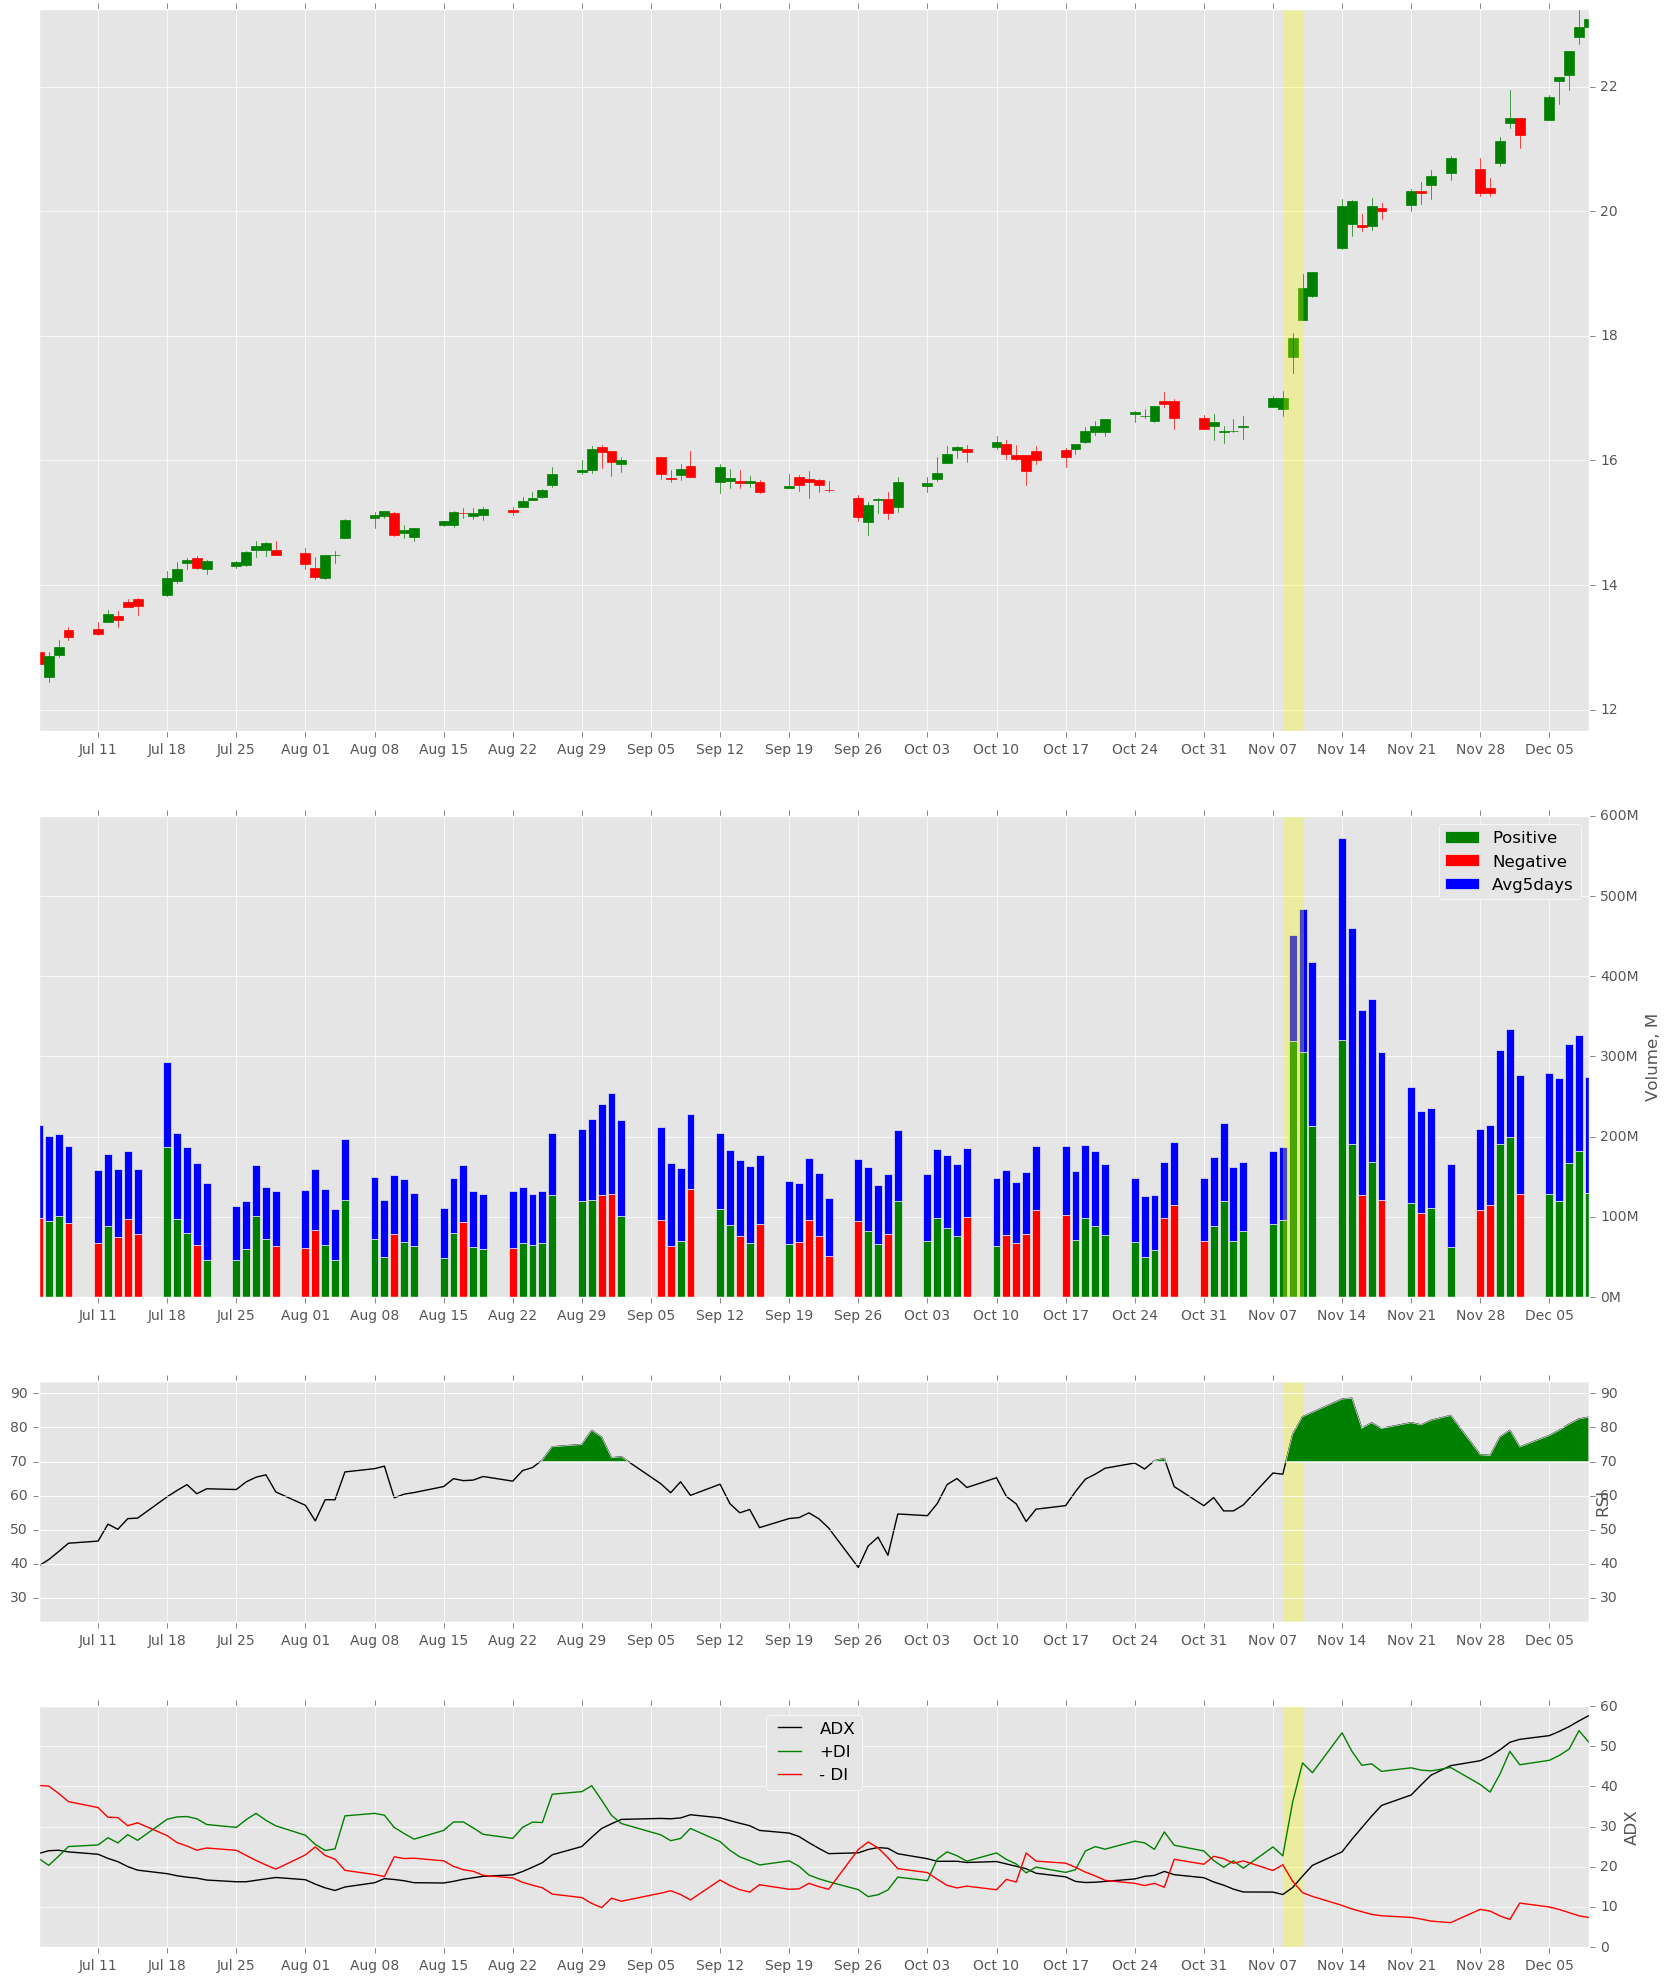

In [23]:
# Visualisation
data = get_data("BAC", days=300)
pattern_instances = get_pattern_instances(data)
print(pattern_instances)

plot_data(data, pattern_instances)

### Now lets get a few instances 

In [24]:
stocks = ('BAC', 'AAPL', 'FB', 'GOOG')

instances = []
for key in stocks:
    data = get_data(key)
    for instance in get_pattern_instances(data):        
        print("found instance on {} in {} data".format(instance.date(), key))
        
        # now lets get the next 50 day data from this date
        gap_index = data.index.get_loc(instance)
        window = data[gap_index:gap_index + 50]
        
        if len(window) < 50:
            print('There are only {} days after {}'.format(len(window), instance.date()))
        
        # and calculate returns
        first_day_open = data.iat[gap_index, 0]
        returns = (window.Close / first_day_open - 1) * 100
        returns.index = range(len(returns))
        instances.append(returns)
        
# merge all returns into one dataframe
result = pd.concat(instances, axis=1, ignore_index=True)
columns_len = len(result.columns)
result

found instance on 2016-11-09 in BAC data
There are only 22 days after 2016-11-09
found instance on 2016-07-28 in FB data
found instance on 2016-07-29 in GOOG data


,0,1,2
0,1.755374,-1.976158,-0.507311
1,6.228766,-2.807399,0.021998
2,7.701019,-2.517251,-0.212242
3,13.703284,-3.473966,0.060821
4,14.156285,-3.928792,-0.142361
5,11.834655,-2.478040,1.230727
6,13.703284,-1.858528,1.171201
7,13.250283,-1.772267,1.494738
8,15.118913,-1.929108,1.549090
9,14.949032,-2.070264,1.571088


### PATTERN MEASURING

#### Measuring criteria:

- Enter into the trade during the next day’s Open Price
- Measure trade’s performance each of 49 trading days based on the close prices for each of the pattern instances (and average it)
- Calculate win and loss rates for each of 49 trading days on the close prices  for each of the pattern instances (and average it)
- Develop charts using matplotlib

In [25]:
result['NegativeCount'] = sum(result[key] < 0 for key in range(columns_len))
result['PositiveCount'] = sum(result[key] > 0 for key in range(columns_len))

def avg_positive(df):
    pos_values = np.array([df[k] for k in range(columns_len) if df[k] > 0])
    if len(pos_values):
        return np.average(pos_values)
    else:
        return 0
    
result['AvgPositive'] = result.apply(avg_positive, axis=1)
result

,0,1,2,NegativeCount,PositiveCount,AvgPositive
0,1.755374,-1.976158,-0.507311,2,1,1.755374
1,6.228766,-2.807399,0.021998,1,2,3.125382
2,7.701019,-2.517251,-0.212242,2,1,7.701019
3,13.703284,-3.473966,0.060821,1,2,6.882053
4,14.156285,-3.928792,-0.142361,2,1,14.156285
5,11.834655,-2.478040,1.230727,1,2,6.532691
6,13.703284,-1.858528,1.171201,1,2,7.437243
7,13.250283,-1.772267,1.494738,1,2,7.372510
8,15.118913,-1.929108,1.549090,1,2,8.334001
9,14.949032,-2.070264,1.571088,1,2,8.260060


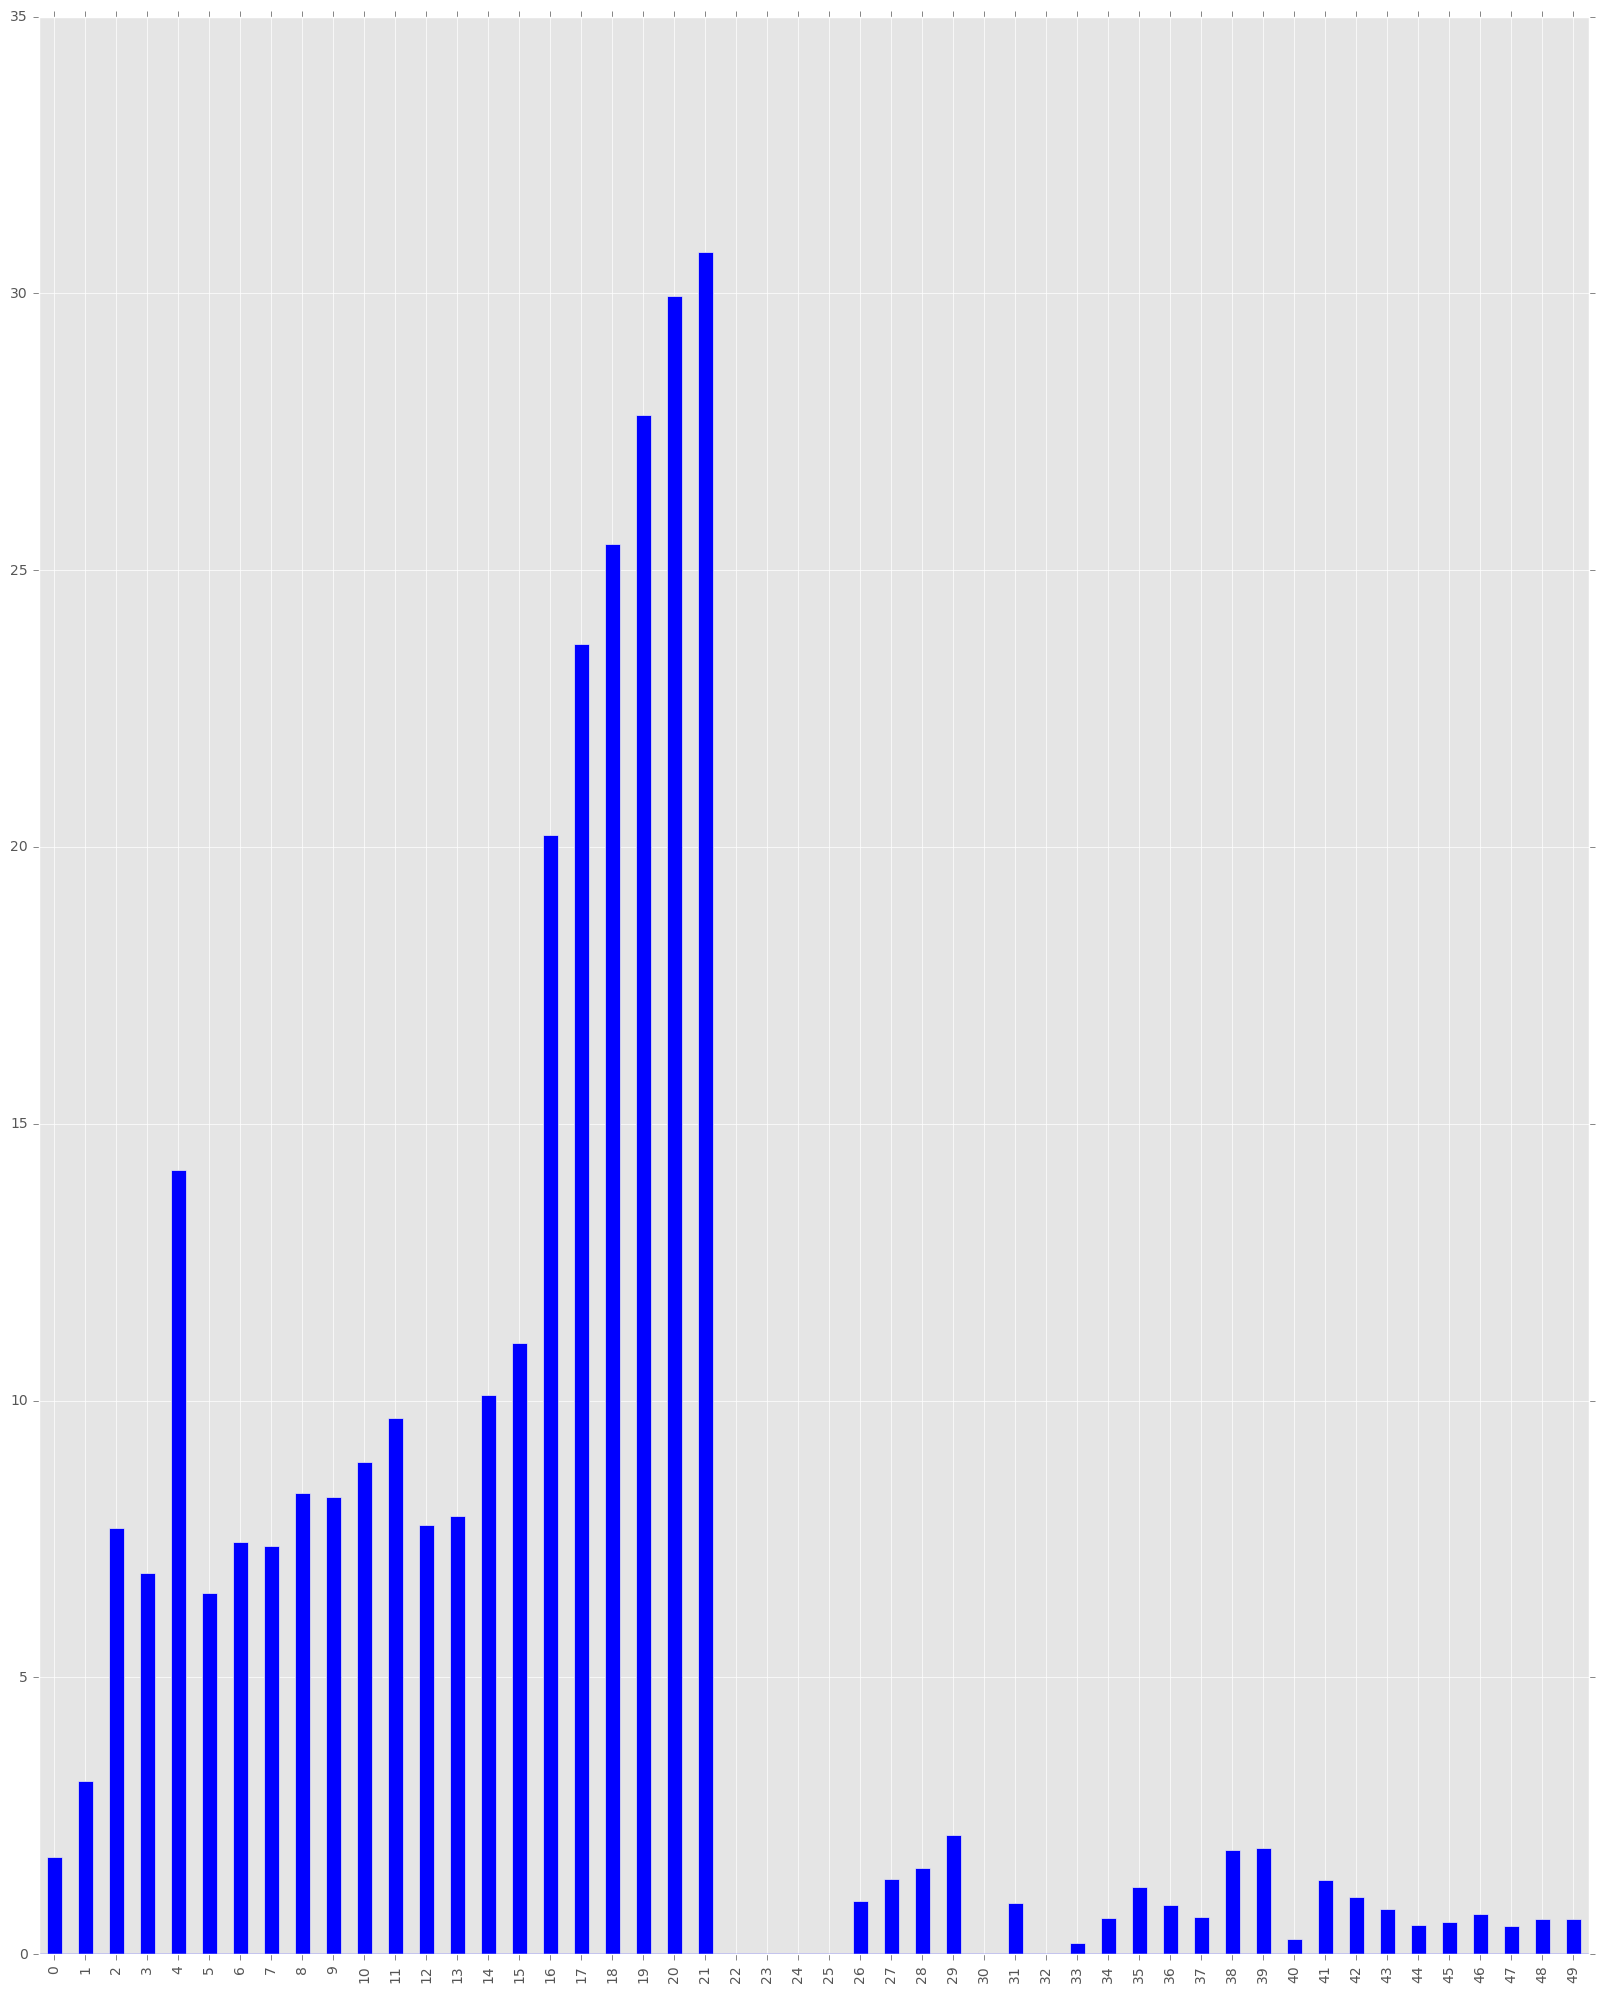

In [42]:
plt.figure(figsize=(20, 25))
result.AvgPositive.plot.bar(color='b')
plt.show()

In [28]:
result['NegativeCount'] = result.NegativeCount * (-1)

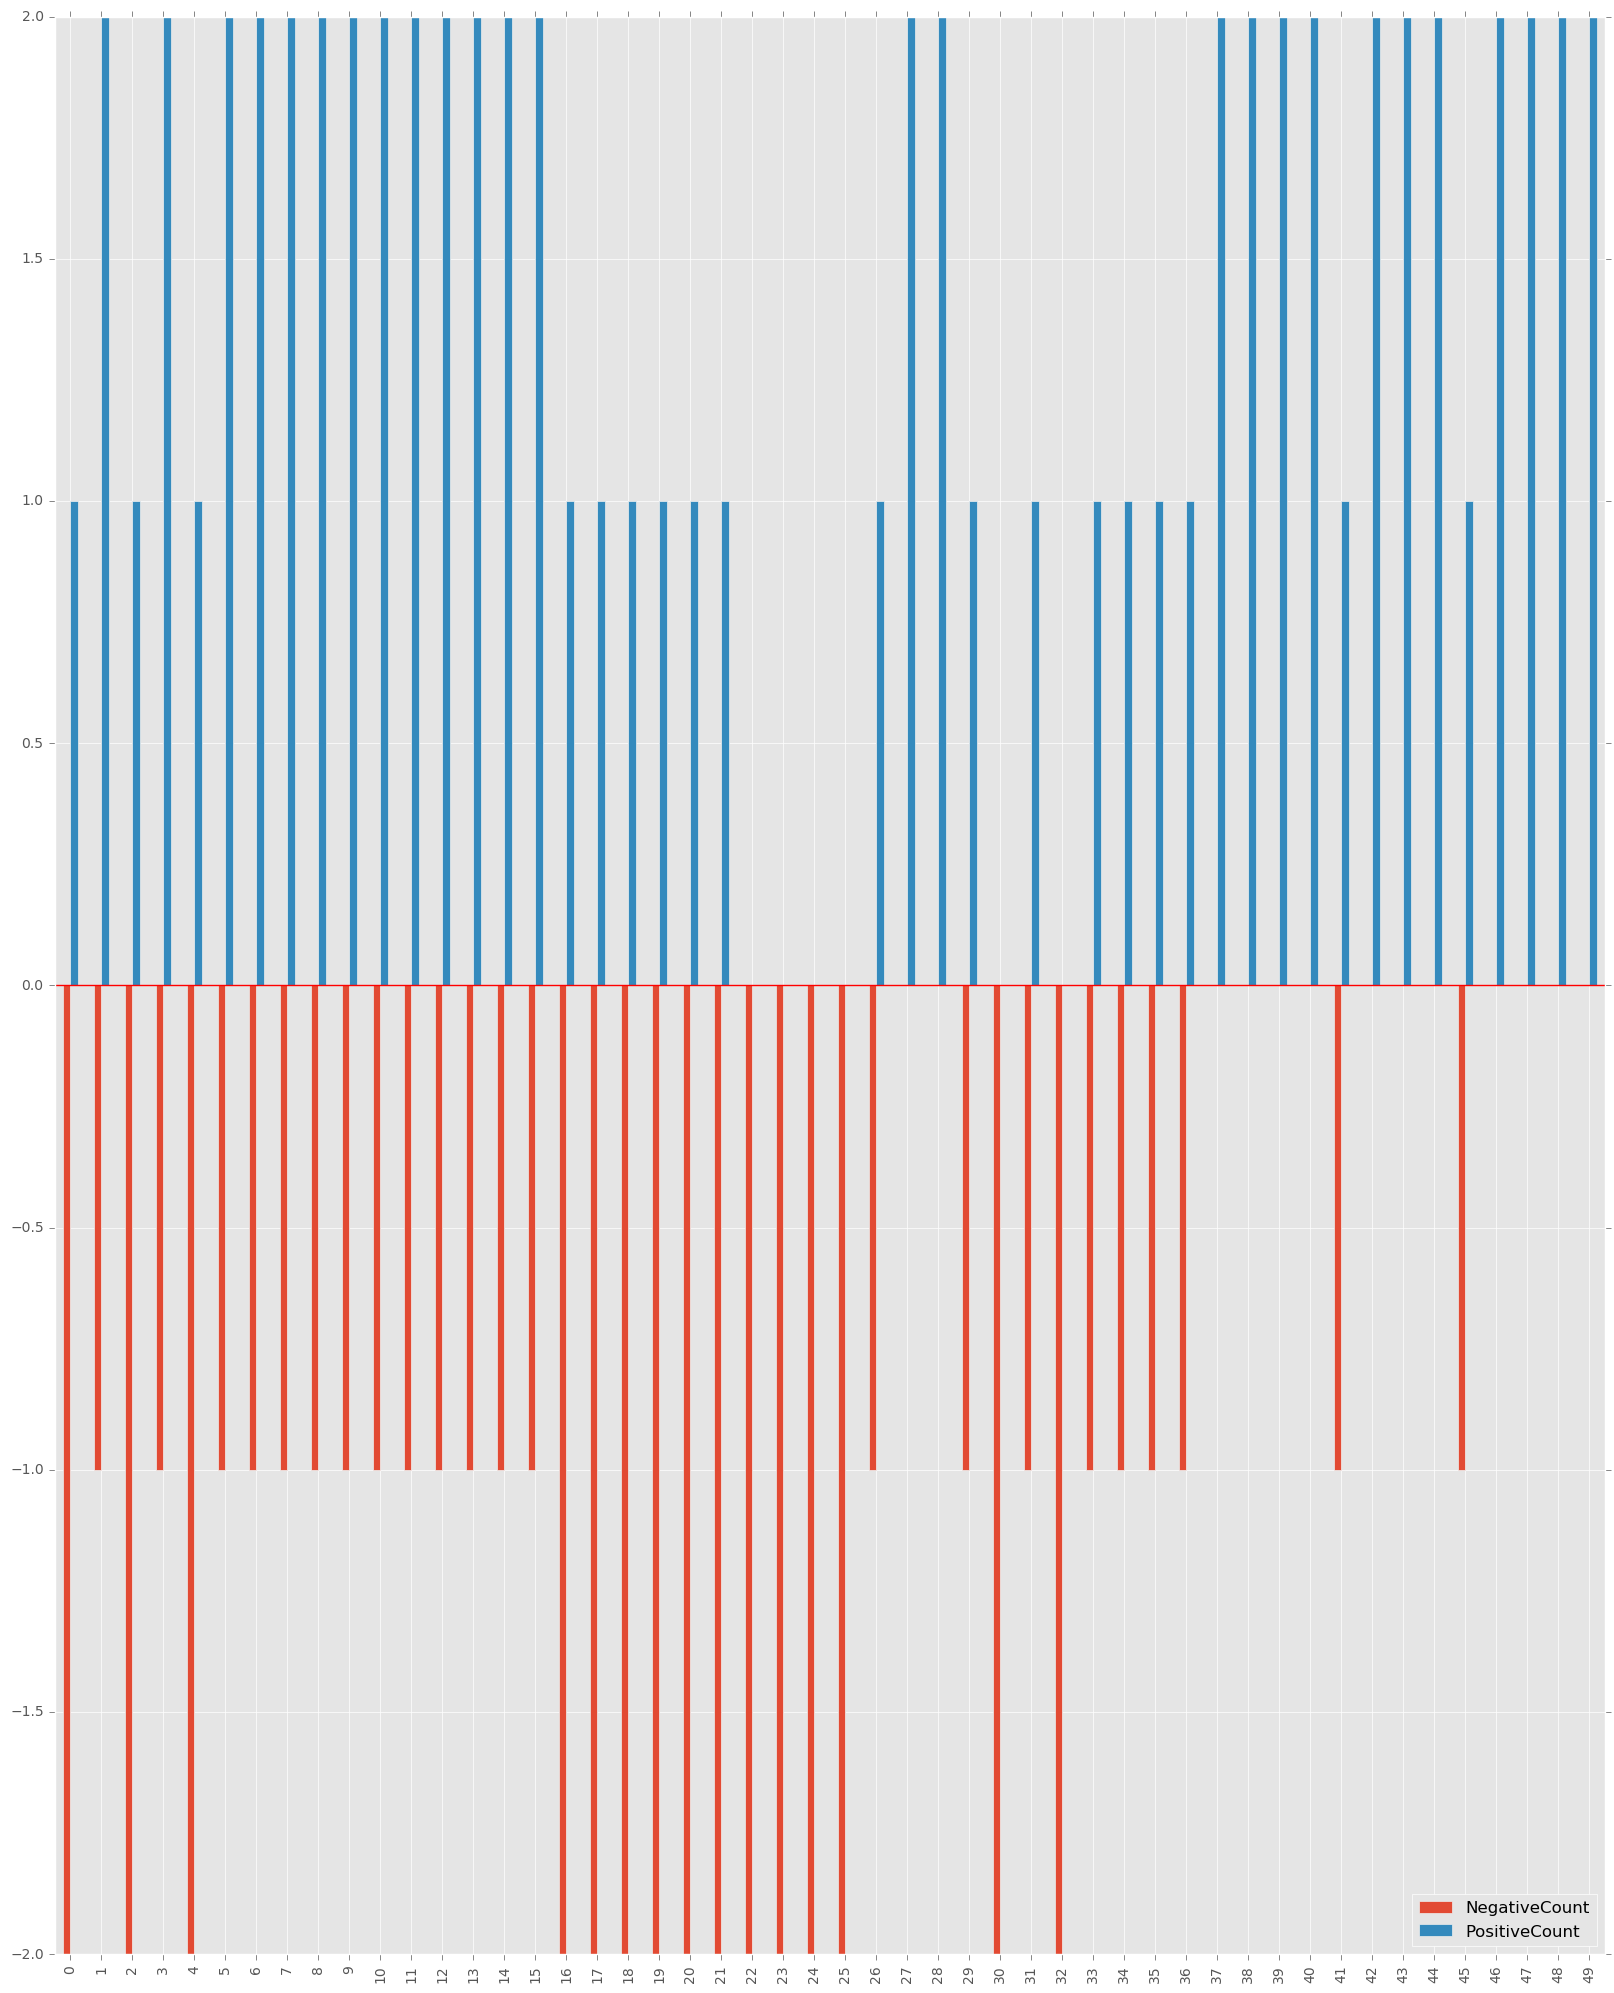

In [38]:
fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(111)
result[['NegativeCount', 'PositiveCount']].plot.bar(ax=ax)
plt.axhline(0, color='r')
plt.show()

In [ ]:
#